# Pipline for waveform analysis A-Z.
### Clustering neural signals associated to cytokine activity.
#### Gabriel Andersson 
---

### Main imports:

In [1]:
import sys
import warnings
import numpy as np
import matplotlib.pyplot as plt

from os import path
sys.path.insert(1,'../')


# General function imports:
from plot_functions_wf import *


# Main Parameters 

In [2]:
unique_string_for_run = 'jupyter_tests'

First pre-process steps of raw plx-file avalible at < qqq. > is done in MATLAB. The resulting files **waveforms** and **timestamps** are saved in the corresponing paths below.

---
## Loading **waveforms** and **timestamps** : 

In [3]:
# HERE THE FILES IS TO BE LOADED
from scipy.io import loadmat
path_to_wf = '../../matlab_files/gg_waveforms-R10_IL1B_TNF_03.mat'
path_to_ts = '../../matlab_files/gg_timestamps.mat'
path_to_raw = '../../matlab_files/R10_6.30.16_BALBC_TNF(0.5ug)_IL1B(35ngperkg)_05rawrec.mat'

waveforms = loadmat(path_to_wf)
#print(f' keys of matlab file: {waveforms.keys()}')
waveforms = waveforms['waveforms']
timestamps = loadmat(path_to_ts)['gg_timestamps']
rawrec = loadmat(path_to_raw)['rawrec']
print('MATLAB files loaded succesfully...')
print()
print(f'Shape of waveforms: {waveforms.shape}.')
print()
print(f'Shape of timestamps: {timestamps.shape}.')
print()
print(f'Shape of raw recording: {rawrec.shape}.')
print()
assert waveforms.shape[0] == timestamps.shape[0], 'Missmatch of waveforms and timestamps shape.'

MATLAB files loaded succesfully...

Shape of waveforms: (136259, 141).

Shape of timestamps: (136259, 1).

Shape of raw recording: (44681339, 1).



## Plot Raw recording and Example of waveforms

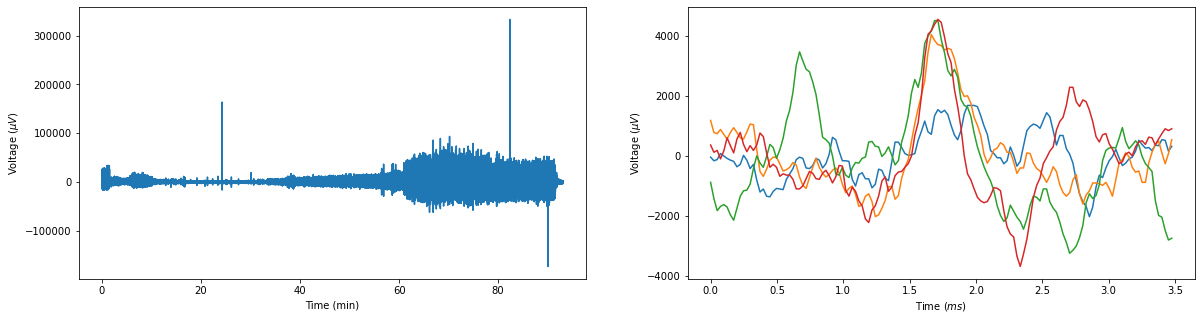

In [4]:
fig = plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plot_rawrec(rawrec, saveas=None,verbose=False)
plt.subplot(1, 2, 2)
plot_waveforms(waveforms[345:349,:],labels=None,verbose=False)
plt.show()

---
## Preprocess of the loaded files. 
The preprocess funtions are avalible in **preprocess_wf.py**

In [4]:
# Preprocess waveforms
#---------------------
import preprocess_wf as preprocess 
# ****STEPS IN PROCESS****
# - Some translation invariant representation? 
# Disregard first and last part since it looks lika artifacts in recording.. 
use_range = np.arange(5000,130000)
waveforms = waveforms[use_range,:]
timestamps = timestamps[use_range]
# - Standardise
wf_std = preprocess.standardise_wf(waveforms)


---
## Event rate threshold and Label the waveforms with their respective change in event rate $\Delta EV$ at time of injections.
### Alternativly use probability given considered waveform as mean. However similar results..
The process goes like: 
- Use tandardise waveforms.
- Calculate correlation $\rho_{ij}$ between each waveform, considering one at a time as the "candidate".
- Consider waveforms as "similar" if $\rho_{ij} > THRES$, for some threshold ($THRES=0.6$). Label these into a cluster with label 1, otherwise 0.
- Calculate event rate for the Candidate-cluster.
- Consider wavefrom as noise if the mean event-rate is below ev_threshold.
- Caclate the change in event rate after injections $\{ \Delta EV_i\}_{i=1}^2$, and consider it sufficient if $\Delta EV_i > \sigma_{ev_i}$, where $\sigma_{ev_i}$ is the standard deviation during the "baseline" period. That is, the time before each injection. 

The nessasary funtions are avalible in **event_rates.py** and **wf_similarity_measure.py**

Experementing with the hyperparameter "THRES" in the notebook "tune_ev_label_hyp_params" lead me choose $THRES=0.6$. This as a result of considering both size of similarity-cluster together with how similar the waveforms actually are within cluster.
- qqq: still no translation invariant measure.

In [5]:
from event_rate_first import *

#from wf_similarity_measures import *
# OBS assumes existance of the standardised waveforms : wf_std
path_to_EVlabels = "../../numpy_files/EV_labels/cvae_27nov_deleteme"

ev_threshold = 1 # Only consider wavefroms with mean event rate above this threshold

if path.isfile(path_to_EVlabels+'.npy'):
    print()
    print(f'Loading saved EV-labels from {path_to_EVlabels}')
    print()
    ev_labels = np.load(path_to_EVlabels+'.npy')
    ev_stats_tot = np.load(path_to_EVlabels+'tests_tot.npy') 
else:
    ev_labels, ev_stats_tot = get_ev_labels(wf_std,timestamps,threshold=0.6,saveas=path_to_EVlabels,similarity_measure='corr')

print(f'Number of wf which ("icreased after first", "increased after second", "constant") = {np.sum(ev_labels,axis=1)} ')

# ho := High Occurance, ts := timestamps
wf_ho, ts_ho, ev_label_ho = preprocess.apply_mean_ev_threshold(wf_std,timestamps,ev_stats_tot[0],ev_threshold=ev_threshold,ev_labels=ev_labels)

print(f'After EV threshold: ("icreased after first", "increased after second", "constant") = {np.sum(ev_label_ho,axis=0)} ')



Loading saved EV-labels from ../../numpy_files/EV_labels/cvae_27nov_deleteme

Number of wf which ("icreased after first", "increased after second", "constant") = [   554.   2502. 120944.] 
After EV threshold: ("icreased after first", "increased after second", "constant") = [    0.  1068. 46059.] 


---
## Plot examples of event-rates for different EV_labeles

Number of waveforms above threshold for wf_idx=29245 : 4548.
Plotting 500...
No given noise..
Number of waveforms above threshold for wf_idx=37787 : 6832.
Plotting 500...
No given noise..


<Figure size 2160x360 with 0 Axes>

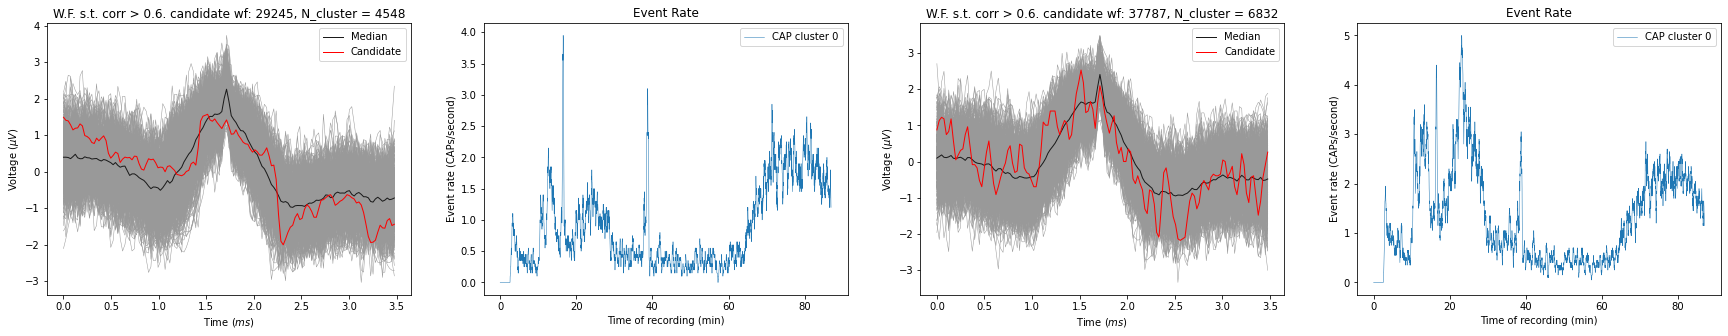

Number of waveforms above threshold for wf_idx=100 : 8709.
Plotting 500...
No given noise..
Number of waveforms above threshold for wf_idx=200 : 9103.
Plotting 500...
No given noise..


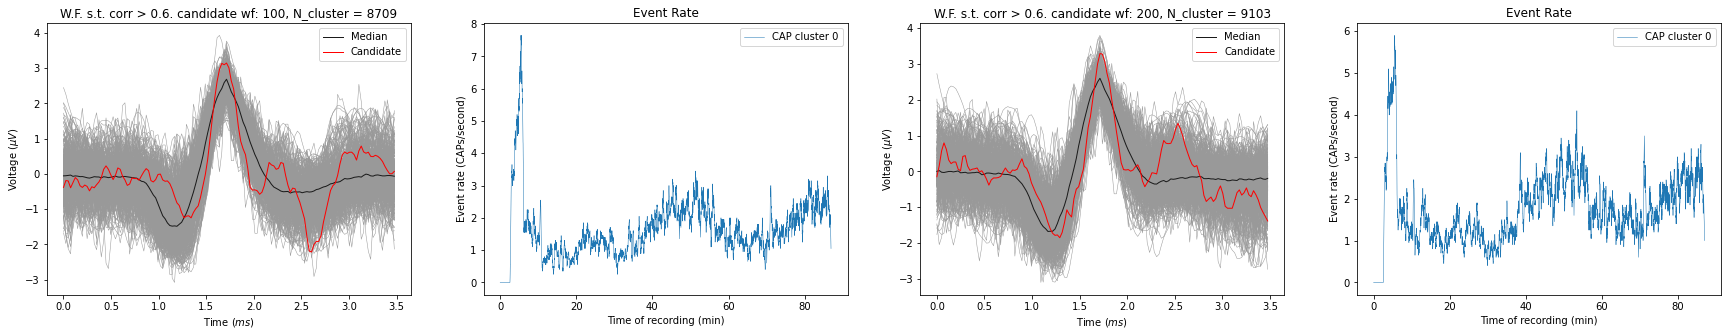

In [46]:
# ************************************************************
# ******** Plot examples of event-rates from EV_labeles ******
# ************************************************************
from wf_similarity_measures import similarity_SSQ
#plot_wf_and_ev_for_the_different_ev_labels = False
saveas_wf_and_ev_for_the_different_ev_labels = '../figures_tests/event_rate_labels/nov30_ev_incr'
threshold = 0.6

for jj in range(3):
    cluster_idx = np.where(ev_label_ho[:,jj]==1)
    saveas = saveas_wf_and_ev_for_the_different_ev_labels +'_cluster_'+str(jj) +'_n_std_1'
    plot_i = 0
    plt.figure(figsize=(30,5))
    for i in cluster_idx[0][100:201:100]: #range(20,100,20):
        #print('increase after {jj+1} injection:')
        correlations = wf_correlation(i,wf_ho)
        bool_labels = label_from_corr(correlations,threshold=threshold,return_boolean=True )
        event_rates, real_clusters = get_event_rates(ts_ho,bool_labels,bin_width=1,consider_only=1)
        delta_ev, ev_stats = delta_ev_measure(event_rates,timestamps=ts_ho.reshape((ts_ho.shape[0],1)))
        ev_labels = ev_label(delta_ev,ev_stats,n_std=1)
        
        plt.subplot(1,4,2*plot_i+1)
        plot_correlated_wf(i,wf_ho,bool_labels,threshold,saveas=None,verbose=False )
        plt.subplot(1,4,2*(plot_i+1))
        plot_event_rates(event_rates,ts_ho,noise=None,conv_width=20,saveas=None, verbose=False) 
        plot_i +=1
    if plot_i >0:
        plt.savefig(saveas+str(jj)+'_wf_corr',dpi=150)
        plt.show()

---
## Sum of Squares as similarity measure: (Gaussian Annulus Theorem)


Using SUMOFSQUARES as similarity measure.

Number of waveforms above threshold for wf_idx=29245 : 1365.
Plotting 500...
No given noise..
Number of waveforms above threshold for wf_idx=37787 : 1922.
Plotting 500...
No given noise..


<Figure size 2160x360 with 0 Axes>

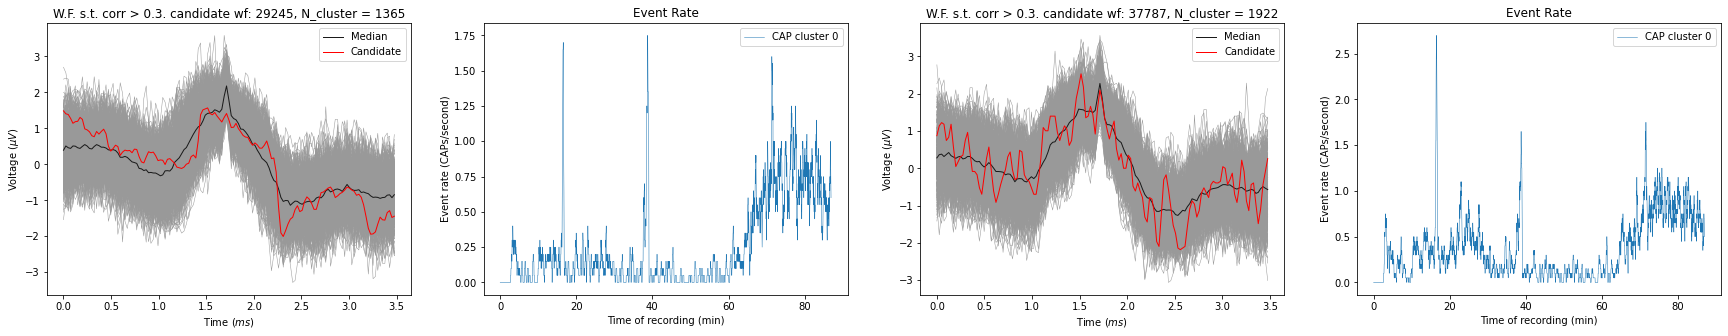

Number of waveforms above threshold for wf_idx=100 : 3646.
Plotting 500...
No given noise..
Number of waveforms above threshold for wf_idx=200 : 4420.
Plotting 500...
No given noise..


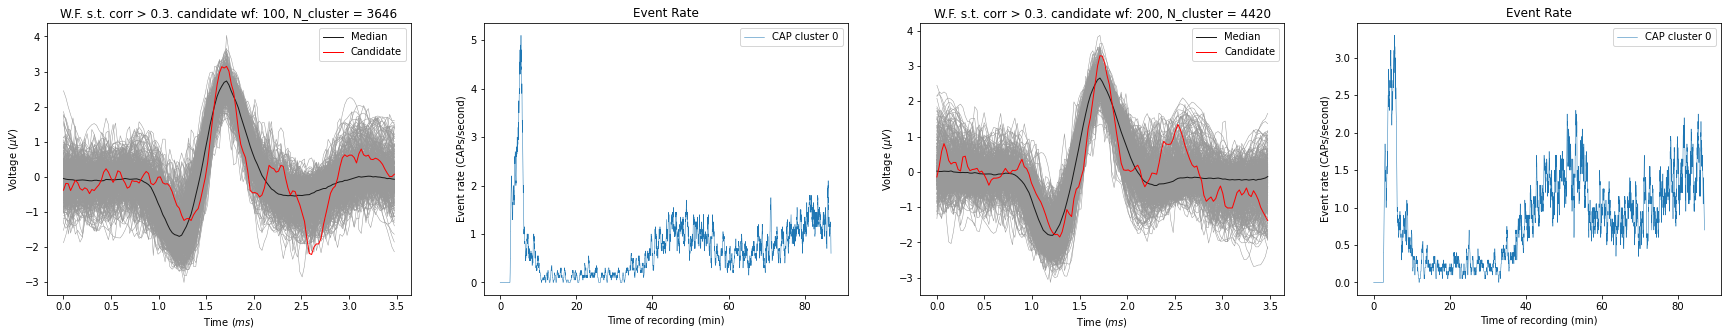

In [47]:
saveas_wf_and_ev_for_the_different_ev_labels = '../figures_tests/event_rate_labels/nov30_ev_incr'
threshold = 0.6
print()
print('Using SUMOFSQUARES as similarity measure.')
print()
eps = 0.3
for jj in range(3):
    cluster_idx = np.where(ev_label_ho[:,jj]==1)
    saveas = saveas_wf_and_ev_for_the_different_ev_labels +'_cluster_'+str(jj) +'SSQ'
    plot_i = 0
    plt.figure(figsize=(30,5))
    for i in cluster_idx[0][100:201:100]: #range(20,100,20):
        candidate_idx = i
        bool_labels,upper_buond = similarity_SSQ(candidate_idx, wf_ho, epsilon=eps, var=0.7)
       
        event_rates, real_clusters = get_event_rates(ts_ho,bool_labels,bin_width=1,consider_only=1)
        delta_ev, ev_stats = delta_ev_measure(event_rates,timestamps=ts_ho.reshape((ts_ho.shape[0],1)))
        ev_labels = ev_label(delta_ev,ev_stats,n_std=1)
        
        plt.subplot(1,4,2*plot_i+1)
        plot_correlated_wf(i,wf_ho,bool_labels,eps,saveas=None,verbose=False )
        plt.subplot(1,4,2*(plot_i+1))
        plot_event_rates(event_rates,ts_ho,noise=None,conv_width=20,saveas=None, verbose=False) 
        plot_i +=1 
    if plot_i >0:
        plt.savefig(saveas+str(jj)+'_wf_SSQ',dpi=150)
        plt.show()

---
## Build and train conditional VAE using labeled data $\mathcal{T} = \{ (x_i, \Delta EV_i) \}_{i=1}^N$

In [6]:
from main_functions import train_model
path_to_weights = '../models/cvae_27nov_deleteme'
continue_train = False
nr_epochs = 20 # if all train data is used -- almost no loss-decrease after 100 batches..
batch_size = 128

# Build and train CVAE -- Probably best to train using terminal and just load saved weights...
encoder,decoder,cvae = train_model(wf_ho, nr_epochs=nr_epochs, batch_size=batch_size, path_to_weights=path_to_weights, 
                                        continue_train=continue_train, verbose=1, ev_label=ev_label_ho)


Loading ../models/cvae_27nov_deleteme...



## Draw samples from resulting probabalistic model obtained by the trained cvae

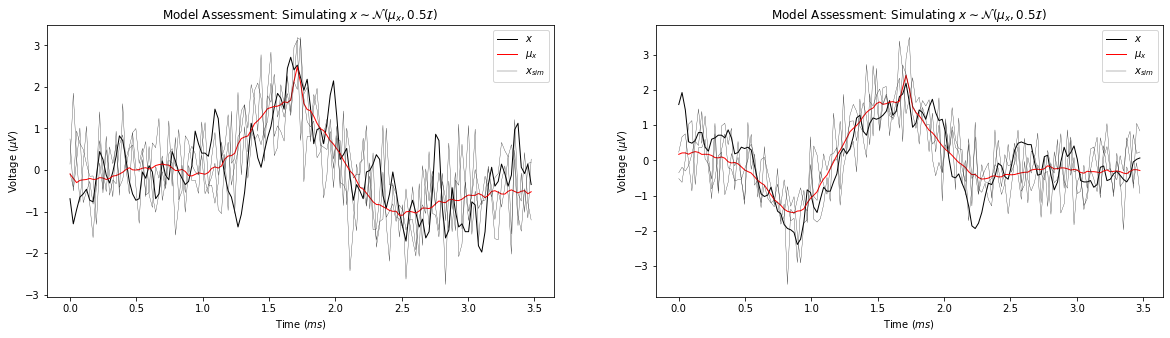

In [9]:
label = np.array((0,0,1)).reshape((1,3))
fig = plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
wf_mean_inp = wf_ho[27,:].reshape((1,141))
plot_simulated(cvae,wf_mean_inp,ev_label=label,n=3,var=0.5, saveas=None, verbose=False)
plt.subplot(1,2,2)
wf_mean_inp = wf_ho[47000,:].reshape((1,141))
plot_simulated(cvae,wf_mean_inp,ev_label=label,n=3,var=0.5, saveas=None, verbose=False)
plt.show()

## Plot resulting decoded latent mean for the different labels
For now only considering two labels since there where no waveforms for which there where an increase in event rate after first injection.

Labeled as increased event rate after second injection:

Constructing plot of decoded latent space...



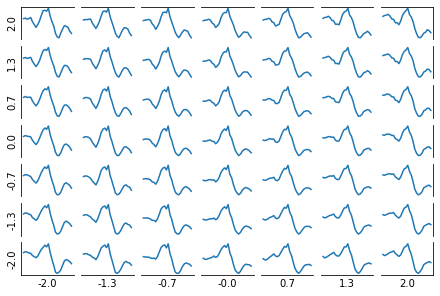

Labeled as constant event rate:

Constructing plot of decoded latent space...



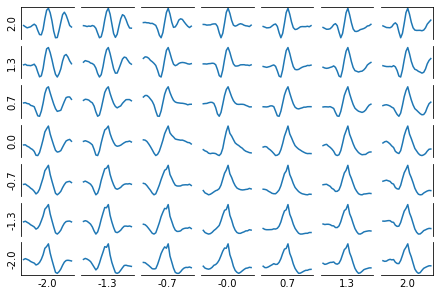

In [9]:
save_figure = '../figures_tests/encoded_decoded/nb' + unique_string_for_run
#print('Labeled as increased event rate after first injection:')
#plot_decoded_latent(decoder,saveas=save_figure+'_decoded_increase_first',verbose=1,ev_label=np.array((1,0,0)).reshape((1,3)))
print('Labeled as increased event rate after second injection:')
plot_decoded_latent(decoder,saveas=save_figure+'_decoded_increase_second',verbose=1,ev_label=np.array((0,1,0)).reshape((1,3)))
print('Labeled as constant event rate:')
plot_decoded_latent(decoder,saveas=save_figure+'_decoded_constant',verbose=1,ev_label=np.array((0,0,1)).reshape((1,3)))

---
## Perform gradiant decent on $I(x|\Delta EV > 0) = - \log p(x|\Delta EV>0)$

The result will be the most probable waveforms given that the event rate increases after injection, or high probability data-points (hpdp). Denote : $\{ \hat{x}_j \}_{j=1}^m$


In [25]:
from main_functions import pdf_GD
# Perform GD on conditional pdf.
path_to_hpdp = "../../numpy_files/numpy_hpdp/cvae_27nov_deleteme"
m=0 # Number of steps 
gamma=0.01 # learning_rate
eta=0.005 # Noise variable -- adds white noise with variance eta to datapoints during GD.


label_on = 1
waveforms_increase_second = wf_ho[ev_label_ho[:,label_on]==1]
ev_label_corr_shape = np.zeros((waveforms_increase_second.shape[0],3))
ev_label_corr_shape[:,label_on] = 1
print(f'waveforms_increase_second : {waveforms_increase_second.shape}')
# To easy computational load -- only every 20th data-point is used..
hpdp = pdf_GD(cvae, waveforms_increase_second,ev_label=ev_label_corr_shape, m=m, gamma=gamma, eta=eta, path_to_hpdp=path_to_hpdp,verbose=1)
#hpdp = pdf_GD(vae, wf_train, m=m, gamma=gamma, eta=eta, path_to_hpdp=path_to_hpdp,verbose=verbose)

waveforms_increase_second : (1068, 141)

Loading ../../numpy_files/numpy_hpdp/cvae_27nov_deleteme as hpdp without performing GD...


High prob. data-points (hpdp): "../../numpy_files/numpy_hpdp/cvae_27nov_deleteme" loaded Succesfully...



## Plot encoded increased event rate hpdp.

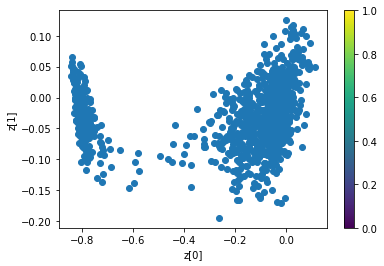

In [26]:
save_figure = '../figures_tests/hpdp/' + unique_string_for_run
plot_encoded(encoder, hpdp, saveas=save_figure+'_encoded_hpdp', verbose=1,ev_label=ev_label_corr_shape)        

## Plot CAPs assosiated to main clusters of hpdp

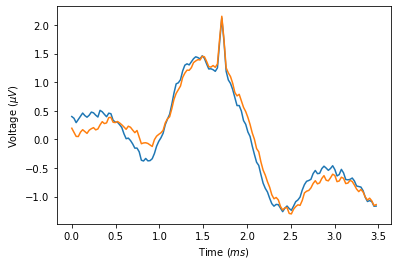

In [27]:
hpdp_label = np.array((0,1,0)).reshape(1,3)
z_hpdp_1 = np.array((-0.8,0)).reshape((1,2))
z_hpdp_2 = np.array((0,-0.05)).reshape((1,2))

X_hpdp_1 = decoder.predict([z_hpdp_1,hpdp_label])
X_hpdp_2 = decoder.predict([z_hpdp_2,hpdp_label])
hpdp_wf_means = np.concatenate((X_hpdp_1,X_hpdp_2),axis=0)
plot_waveforms(hpdp_wf_means,labels=None)


---
## Consider the mean of the most probable CAP given ”significant” increase in event-rate as the ”MAIN-candidates” for encoding cytokine specific information.
Plot associated similarity clusters and their respective event-rate

Bool labels = [ True False False False False False False False False False]...
Number of waveforms above threshold for wf_idx=0 : 5763.
Plotting 500...


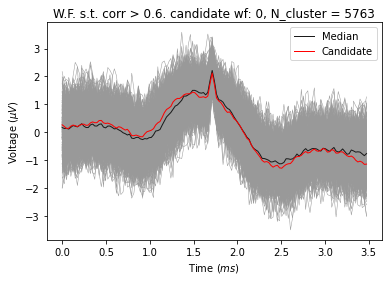

No given noise..


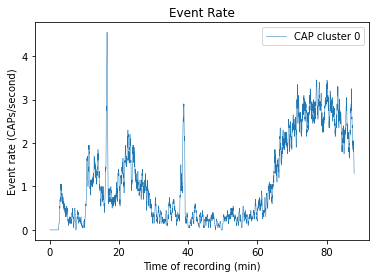

In [28]:
# Final labeling
gd_runs = '_4000'
saveas = '../figures_tests/event_rate_labels/'+unique_string_for_run+gd_runs


bool_labels = np.ones((hpdp.shape[0])) == 1 # Label all as True (same cluster) to plot the average form of increased EV-hpdp
#plot_correlated_wf(0,hpdp,bool_labels,None,saveas=saveas+'_wf',verbose=True)

MAIN_CANDIDATE = np.median(hpdp,axis=0)

added_main_candidate_wf = np.concatenate((MAIN_CANDIDATE.reshape((1,MAIN_CANDIDATE.shape[0])),wf_std),axis=0)
assert np.sum(MAIN_CANDIDATE) == np.sum(added_main_candidate_wf[0,:]), 'Something wrong in concatenate..'

# Get correlation cluster for Delta EV - increased_second hpdp
MAIN_THRES = 0.6
correlations = wf_correlation(0,added_main_candidate_wf)
bool_labels = label_from_corr(correlations,threshold=MAIN_THRES,return_boolean=True)
print(f'Bool labels = {bool_labels[:10]}...')
event_rates, real_clusters = get_event_rates(timestamps,bool_labels[1:],bin_width=1,consider_only=1)

plot_correlated_wf(0,added_main_candidate_wf,bool_labels,MAIN_THRES,saveas=saveas+'Main_cand'+'_wf',verbose=True )
plot_event_rates(event_rates,timestamps,noise=None,conv_width=20,saveas=saveas+'Main_cand'+'_ev', verbose=True) 

---
## Consider the mean of the most probable CAP given ”significant” increase in event-rate as the ”MAIN-candidates” for encoding cytokine specific information.
### Using SSQ
Plot associated similarity clusters and their respective event-rate

Bool labels = [False False False False False False False False False False]...
Number of waveforms above threshold for wf_idx=0 : 4422.
Plotting 500...


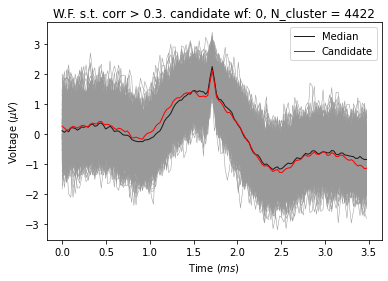

No given noise..


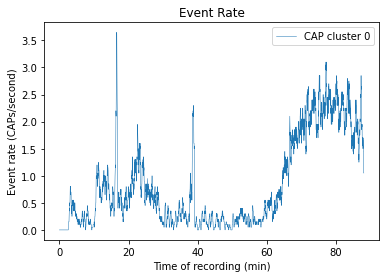

In [43]:
# Final labeling
gd_runs = '_4000'
saveas = '../figures_tests/event_rate_labels/'+unique_string_for_run+gd_runs


bool_labels = np.ones((hpdp.shape[0])) == 1 # Label all as True (same cluster) to plot the average form of increased EV-hpdp
#plot_correlated_wf(0,hpdp,bool_labels,None,saveas=saveas+'_wf',verbose=True)

MAIN_CANDIDATE = np.median(hpdp,axis=0)

added_main_candidate_wf = np.concatenate((MAIN_CANDIDATE.reshape((1,MAIN_CANDIDATE.shape[0])),wf_std),axis=0)
assert np.sum(MAIN_CANDIDATE) == np.sum(added_main_candidate_wf[0,:]), 'Something wrong in concatenate..'

# Get correlation cluster for Delta EV - increased_second hpdp
eps = 0.3
#correlations = wf_correlation(0,added_main_candidate_wf)
#bool_labels = label_from_corr(correlations,threshold=MAIN_THRES,return_boolean=True)
bool_labels,upper_buond = similarity_SSQ(0, added_main_candidate_wf, epsilon=eps, var=0.6)
print(f'Bool labels = {bool_labels[:10]}...')
event_rates, real_clusters = get_event_rates(timestamps,bool_labels[1:],bin_width=1,consider_only=1)

plot_correlated_wf(0,added_main_candidate_wf,bool_labels,eps,saveas=saveas+'Main_cand'+'_wf',verbose=True )
plot_event_rates(event_rates,timestamps,noise=None,conv_width=20,saveas=saveas+'Main_cand'+'_ev', verbose=True) 